In [1]:
import glob
import json
import pandas as pd
from src.helper import get_int

In [2]:
%matplotlib inline

# data check (see bottom)
1. projects location has 1 unique woeid
2. accessing communities pages in diff time gives different backers
3. top 10 backer ratio: city-level is bad but country-level is doable

In [3]:
# load data
prjs_url = pd.read_csv('data/projects_url.csv')
prjs_loc = pd.read_csv('data/projects_location.csv')
prjs_info = pd.read_csv('data/projects_features.csv')
prjs_woeid = pd.read_csv('data/projects_woeid.csv')
prjs_backer_cities = pd.concat([pd.read_csv(fn)for fn in glob.glob('data/scraped/patch-woeid/projs*cities*.csv')])
prjs_backer_countries = pd.concat([pd.read_csv(fn)for fn in glob.glob('data/scraped/patch-woeid/projs*countries*.csv')])

In [4]:
# clean data

## successful as positive = 1
print prjs_info.state.value_counts().to_dict()
prjs_info.state = prjs_info.state.apply(lambda x: 1 if x=='successful' else 0)

## get int of cnt
prjs_backer_cities.cnt = prjs_backer_cities.cnt.apply(get_int)
prjs_backer_countries.cnt = prjs_backer_countries.cnt.apply(get_int)

{'successful': 60672, 'failed': 61919}


In [16]:
prjs_info[['category_parent','category_name']].nunique()

category_parent     15
category_name      131
dtype: int64

In [9]:
# build woeid dictionary

## woeid in projs
prjs_loc['loc_name'] = prjs_loc.apply(lambda x: '{}, {}, {}'.format(str(x.proj_location_name), str(x.proj_state), str(x.proj_country)), axis=1)
woeid2name = prjs_woeid.merge(prjs_loc[['id', 'loc_name']]).drop('id', axis=1)
woeid2name = woeid2name[~woeid2name.duplicated()].set_index('proj_woeid')

## woeid in backers cities
prjs_backer_cities['loc_name_2nd'] = prjs_backer_cities.apply(lambda x: '{}, {}'.format(x.city, x.country), axis=1)
woeid2name_2nd = prjs_backer_cities[['woeid', 'loc_name_2nd']]
woeid2name_2nd = woeid2name_2nd[~woeid2name_2nd.duplicated()].set_index('woeid')

## merge them
woeid2name = woeid2name.merge(woeid2name_2nd,left_index=True, right_index=True, how='outer')
woeid2name['name'] = woeid2name.apply(lambda x: x.loc_name if pd.notnull(x.loc_name) else x.loc_name_2nd, axis=1)
woeid2name = woeid2name['name'].to_dict()

'# total locations:', len(woeid2name)

('# total locations:', 29827)

In [6]:
# build network
## get directed network edges
backer_wise_df = prjs_info[['id', 'category_parent']].merge(prjs_backer_cities[['id', 'woeid', 'cnt']]).merge(prjs_woeid).drop('id', axis=1)
edges = backer_wise_df.groupby(['woeid', 'proj_woeid', 'category_parent']).sum().reset_index()

## get des node attributes
des_nodes = prjs_info[['id','state', 'usd_pledged', 'category_parent', '#backer']].merge(prjs_woeid)\
              .groupby(['proj_woeid', 'category_parent'])\
              .agg({'id': 'count', 'state':'mean', 'usd_pledged':['sum', 'mean'], '#backer':['sum','mean']})
attr = ['des_%scfl', 'des_total_backer_sum','des_total_backer_mean', 'des_#projects', 'des_$pld_sum', 'des_$pld_mean']
print 'make sure the columns order is correct', zip(attr, des_nodes.columns.to_native_types())
des_nodes.columns = attr

## merge des node attrbutes
network = edges.merge(des_nodes.reset_index())
network.columns = ['src', 'des', 'category', 'src_backers'] + list(network.columns[4:])

edges.shape, des_nodes.shape, network.shape



make sure the columns order is correct [('des_%scfl', ('state', 'mean')), ('des_total_backer_sum', ('#backer', 'sum')), ('des_total_backer_mean', ('#backer', 'mean')), ('des_#projects', ('id', 'count')), ('des_$pld_sum', ('usd_pledged', 'sum')), ('des_$pld_mean', ('usd_pledged', 'mean'))]


((409703, 4), (29305, 6), (409703, 10))

In [12]:
a,b = edges[['woeid', 'proj_woeid']].nunique().values
print '# cities as src:', a, '# cities as des:', b

# cities as src: 22778 # cities as des: 7708


In [7]:
network.src = network.src.apply(lambda x: woeid2name[x])
network.des = network.des.apply(lambda x: woeid2name[x])

In [25]:
for i in range(20):
    print i, des_nodes[des_nodes['des_#projects']>i].shape[0], network[network['des_#projects']>i].shape[0]

0 29305 409703
1 10250 323761
2 5999 284493
3 4311 260536
4 3402 244338
5 2766 230201
6 2397 220567
7 2106 211964
8 1866 203622
9 1682 196948
10 1529 190808
11 1400 185435
12 1276 179744
13 1175 174854
14 1095 170831
15 1026 167183
16 970 163723
17 917 160524
18 864 157180
19 816 153916


In [8]:
network.to_csv('data/pledge_network_edges.csv')

In [17]:
des_nodes_to_save = des_nodes.reset_index()
des_nodes_to_save.proj_woeid = des_nodes_to_save.proj_woeid.apply(lambda x: woeid2name[x])
des_nodes_to_save.columns = ['des', 'category'] + des_nodes_to_save.columns[2:].tolist()
des_nodes_to_save.to_csv('data/pledge_network_nodes.csv')

In [22]:
thres = 10
network[network['des_#projects']>thres].to_csv('data/pledge_network_edges_thres_10.csv')
des_nodes_to_save[des_nodes_to_save['des_#projects']>thres].to_csv('data/pledge_network_nodes_thres_10.csv')

In [16]:
des_nodes_to_save.columns

Index([u'des', u'category', u'des_%scfl', u'des_total_backer_sum',
       u'des_total_backer_mean', u'des_#projects', u'des_$pld_sum',
       u'des_$pld_mean'],
      dtype='object')

pledge_network_nodes:
- 以(des, category)为id，比如，第一行表示Ajax, ON, CA在design这个类别下有3个项目，Ajax, ON, CA在photography有1个项目
- des_%scfl：(des, category)的所有项目中，成功的比例
- des_total_backer_sum：(des, category)的所有项目中，总共的backers的人次
- des_total_backer_mean：des_total_backer_sum/des_#projects
- des_#projects：(des, category)有多少个项目
- des_\$pld_sum：(des, category)所有项目总共筹到的钱，美金为单位
- des_\$pld_mean：des_$pld_sum/des_#projects

pledge_network_edges:
- 以(src, des, category)为id，比如第2行是总共有1个（src_backers）来自Markham, ON, CA的backers 出现在Ajax, ON, CA的publish项目中的top 10 backers cities中。
- 其他的字段和pledge_network_nodes相同含义，都是des的属性

# deprecated

In [38]:
prjs_loc = prjs_loc[prjs_loc.proj_location_type!='Zip']

In [14]:
prjs_info[['id', 'usd_pledged', 'category_parent', 'category_name']].head()
prjs_loc[['id', 'proj_location_display_name']]

,id,usd_pledged,category_parent,category_name
0,515397789,18306.00,film & video,Webseries
1,2078514446,1500.00,film & video,Webseries
2,8445205,7065.01,film & video,Webseries
3,472273248,10015.00,film & video,Webseries
4,1755519177,1920.00,film & video,Webseries


In [61]:
unique_locs = prjs_loc.proj_location_display_name.value_counts().index.tolist()

In [67]:
prjs_loc_no_dplct[prjs_loc_no_dplct.proj_location_name=='Madison']

,id,proj_country,proj_state,proj_location_type,proj_location_name,proj_location_display_name,bio_loc,profile_loc,backer_cities,backer_countries
0,515397789,US,WI,Town,Madison,"Madison, WI","Madison, WI","Madison, WI","[{""city"": ""Madison"", ""cnt"": ""42"", ""country"": ""...","[{""country"": ""United States"", ""cnt"": ""87""}, {""..."
4339,1417931569,US,MS,Town,Madison,"Madison, MS","Madison, MS","Madison, MS",NaN,NaN
15188,977773143,US,NJ,Town,Madison,"Madison, NJ","Madison, NJ","Madison, NJ","[{""city"": ""New York"", ""cnt"": ""7"", ""country"": ""...","[{""country"": ""United States"", ""cnt"": ""170""}, {..."
29565,525420010,US,AL,Town,Madison,"Madison, AL","Madison, AL","Madison, AL",NaN,NaN
31437,313421741,US,NC,Town,Madison,"Madison, NC","Reidsville, NC",NaN,NaN,NaN
47023,1590743808,US,IN,Town,Madison,"Madison, IN","Warwick, NY","Warwick, NY",NaN,NaN
69805,229809258,US,SD,Town,Madison,"Madison, SD","Sioux Falls, SD","Sioux Falls, SD","[{""city"": ""Mobridge"", ""cnt"": ""4"", ""country"": ""...","[{""country"": ""United States"", ""cnt"": ""23""}]"
73756,1894655603,US,CT,Town,Madison,"Madison, CT","Madison, CT","Madison, CT","[{""city"": ""Guilford"", ""cnt"": ""9"", ""country"": ""...","[{""country"": ""United States"", ""cnt"": ""118""}, {..."
87100,355545007,US,VA,Town,Madison,"Madison, VA","Madison, VA","Madison, VA",NaN,NaN
105253,212660357,US,TN,Suburb,Madison,"Madison, Nashville, TN","Dickson, TN","Dickson, TN",NaN,NaN


In [66]:
res = []
for i, line in prjs_loc.iterrows():
    print line
    backers_cities = json.loads(line.backer_cities)
    for c in backers_cities:
        cnt = c['cnt']
        city = c['city']
        name = [n for n in unique_locs if city.encode('utf8') in n]
        print name
        assert len(name) ==1
    break

id                                                                    515397789
proj_country                                                                 US
proj_state                                                                   WI
proj_location_type                                                         Town
proj_location_name                                                      Madison
proj_location_display_name                                          Madison, WI
bio_loc                                                             Madison, WI
profile_loc                                                         Madison, WI
backer_cities                 [{"city": "Madison", "cnt": "42", "country": "...
backer_countries              [{"country": "United States", "cnt": "87"}, {"...
Name: 0, dtype: object
['Madison, WI', 'Madison, AL', 'Madison, MS', 'Madisonville, KY', 'Madison, NJ', 'Madisonville, LA', 'Madison, NC', 'Madison, IN', 'Fort Madison, IA', 'Madison, CT', 'Madison, N

AssertionError: 

In [6]:
import json

In [11]:
json.loads(prjs_loc.backer_cities[0])

[{u'city': u'Madison', u'cnt': u'42', u'country': u'United States'},
 {u'city': u'Los Angeles', u'cnt': u'3', u'country': u'United States'},
 {u'city': u'Milwaukee', u'cnt': u'3', u'country': u'United States'},
 {u'city': u'Evansville', u'cnt': u'2', u'country': u'United States'},
 {u'city': u'Minneapolis', u'cnt': u'2', u'country': u'United States'},
 {u'city': u'Oregon', u'cnt': u'2', u'country': u'United States'},
 {u'city': u'Orfordville', u'cnt': u'2', u'country': u'United States'},
 {u'city': u'Waterloo', u'cnt': u'2', u'country': u'United States'},
 {u'city': u'Tokyo', u'cnt': u'1', u'country': u'Japan'},
 {u'city': u'Auckland', u'cnt': u'1', u'country': u'New Zealand'}]

In [45]:
prjs_loc_no_dplct = prjs_loc[~prjs_loc[['proj_country', 'proj_state','proj_location_name', 'proj_location_display_name']].duplicated()]

In [51]:
names = prjs_loc_no_dplct.proj_location_display_name.value_counts()

In [55]:
target = set(names[names!=1].index)

In [57]:
prjs_loc_no_dplct[prjs_loc_no_dplct.proj_location_display_name.isin(target)].sort_values('proj_location_display_name')

,id,proj_country,proj_state,proj_location_type,proj_location_name,proj_location_display_name,bio_loc,profile_loc,backer_cities,backer_countries
12780,280450557,AU,NSW,Suburb,Abbotsford,"Abbotsford, AU","Daylesford, AU","Daylesford, AU",NaN,NaN
20877,1782575105,AU,VIC,Suburb,Abbotsford,"Abbotsford, AU","Abbotsford, AU","Abbotsford, AU",NaN,NaN
14233,1461979147,IN,Jharkhand,Town,Asia,"Asia, India","Corona, CA",NaN,NaN,NaN
58712,1585213751,IN,Bihar,Town,Asia,"Asia, India","Växjö, Sweden",NaN,NaN,NaN
105729,651289291,CA,QC,Town,Aylmer,"Aylmer, Canada","Gatineau, Canada","Gatineau, Canada",NaN,NaN
119522,1765502523,CA,ON,Town,Aylmer,"Aylmer, Canada","Gatineau, Canada",NaN,NaN,NaN
48904,443310737,CA,ON,Suburb,Beaconsfield,"Beaconsfield, Canada","Beaconsfield, Canada","Beaconsfield, Canada",NaN,NaN
4940,412781415,CA,QC,Suburb,Beaconsfield,"Beaconsfield, Canada","Beaconsfield, Canada",NaN,"[{""city"": ""Montreal"", ""cnt"": ""2"", ""country"": ""...","[{""country"": ""Canada"", ""cnt"": ""8""}, {""country""..."
3715,1821611312,GB,England,Town,Blackburn,"Blackburn, UK","Blackburn, UK",NaN,NaN,NaN
85785,1450939958,GB,Scotland,Town,Blackburn,"Blackburn, UK","Blackburn, UK","Blackburn, UK","[{""city"": ""London"", ""cnt"": ""15"", ""country"": ""U...","[{""country"": ""United Kingdom"", ""cnt"": ""72""}, {..."


In [35]:
prjs_loc[prjs_loc.proj_location_display_name=='Los Angeles, CA'][~prjs_loc[['proj_country', 'proj_state','proj_location_name', 'proj_location_display_name']].duplicated()]

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,id,proj_country,proj_state,proj_location_type,proj_location_name,proj_location_display_name,bio_loc,profile_loc,backer_cities,backer_countries
1,2078514446,US,CA,Town,Los Angeles,"Los Angeles, CA","Los Angeles, CA",NaN,"[{""city"": ""Chicago"", ""cnt"": ""10"", ""country"": ""...","[{""country"": ""United States"", ""cnt"": ""29""}, {""..."
3562,1570922930,US,CA,Zip,90005,"Los Angeles, CA","Los Angeles, CA","Los Angeles, CA",NaN,NaN
9363,1415774204,US,CA,Zip,91356,"Los Angeles, CA","Los Angeles, CA",NaN,NaN,NaN
48518,1085965288,US,CA,Zip,90025,"Los Angeles, CA","Los Angeles, CA","Los Angeles, CA","[{""city"": ""Los Angeles"", ""cnt"": ""22"", ""country...","[{""country"": ""United States"", ""cnt"": ""40""}, {""..."
70947,591442232,US,CA,Zip,90731,"Los Angeles, CA","Los Angeles, CA",NaN,NaN,NaN


In [34]:
prjs_loc[prjs_loc.proj_location_display_name=='Fukuoka, Japan'][~prjs_loc[['proj_country', 'proj_state','proj_location_name', 'proj_location_display_name']].duplicated()]

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,id,proj_country,proj_state,proj_location_type,proj_location_name,proj_location_display_name,bio_loc,profile_loc,backer_cities,backer_countries
20344,758996342,JP,Shizuoka Prefecture,LocalAdmin,Fukuoka,"Fukuoka, Japan","Brooklyn, NY",NaN,"[{""city"": ""Brooklyn"", ""cnt"": ""6"", ""country"": ""...","[{""country"": ""United States"", ""cnt"": ""24""}, {""..."
90186,1911113719,JP,Gifu Prefecture,LocalAdmin,Fukuoka,"Fukuoka, Japan","Fukuoka, Japan","Fukuoka, Japan","[{""city"": ""Singapore"", ""cnt"": ""55"", ""country"":...","[{""country"": ""United States"", ""cnt"": ""339""}, {..."
104069,1041056290,JP,Miyagi Prefecture,LocalAdmin,Fukuoka,"Fukuoka, Japan","Fukuoka, Japan","Fukuoka, Japan","[{""city"": ""Singapore"", ""cnt"": ""22"", ""country"":...","[{""country"": ""United States"", ""cnt"": ""547""}, {..."


In [29]:
prjs_loc.proj_location_display_name.value_counts()

Los Angeles, CA                      6461
New York, NY                         4796
London, UK                           3487
Chicago, IL                          2486
San Francisco, CA                    2258
Brooklyn, NY                         2187
Seattle, WA                          1764
Portland, OR                         1602
Austin, TX                           1495
Atlanta, GA                          1489
Nashville, TN                        1470
Boston, MA                           1371
Minneapolis, MN                      1059
San Diego, CA                        1052
Philadelphia, PA                     1047
Denver, CO                           1024
Dallas, TX                            968
Washington, DC                        946
Toronto, Canada                       944
Houston, TX                           930
Las Vegas, NV                         750
Orlando, FL                           743
Phoenix, AZ                           709
Salt Lake City, UT                

# data check

## loc and woeid 1 on 1 match? Yes

In [72]:
df = prjs_woeid.merge(prjs_loc)
df['loc_name'] = df.apply(lambda x: str(x.proj_country) + str(x.proj_state) + str(x.proj_location_name), axis=1)
df[['proj_woeid', 'loc_name']].groupby('proj_woeid').nunique().loc_name.value_counts()

1    12370
Name: loc_name, dtype: int64

## accessing communities in different time gives different backers result(small proportion)

In [17]:
prjs_loc['backer_cities_len'] = prjs_loc.backer_cities.apply(lambda x: len(json.loads(x)) if pd.notnull(x) else '')
df_org = prjs_loc[['id', 'backer_cities_len']]
df_cnt = prjs_backer_cities.groupby('id').agg('count')
df = df_org.merge(df_cnt.reset_index())


In [18]:
print df_cnt.shape, df_org.shape, df[(df.backer_cities_len!=df.city)].shape
df[(df.backer_cities_len!=df.city)].head()

(95098, 5) (122591, 2) (131, 7)


,id,backer_cities_len,city,cnt,country,woeid,loc_name_2nd
818,419922355,7,8,8,8,8,8
931,1225411862,8,9,9,9,9,9
1014,725240675,4,3,3,3,3,3
1266,118561147,7,8,8,8,8,8
1747,550198119,7,8,8,8,8,8


In [19]:
i = df.id.iloc[1]
print i

print prjs_url[prjs_url.id==i].url.iloc[0]
for x in json.loads(prjs_loc[prjs_loc.id==i].backer_cities.values[0]):
    print x

prjs_backer_cities[prjs_backer_cities.id==i]

2078514446
https://www.kickstarter.com/projects/2133731457/day-job-support-group-a-webseries
{u'city': u'Chicago', u'cnt': u'10', u'country': u'United States'}
{u'city': u'Lexington', u'cnt': u'3', u'country': u'United States'}
{u'city': u'Minneapolis', u'cnt': u'2', u'country': u'United States'}
{u'city': u'St. Louis', u'cnt': u'2', u'country': u'United States'}
{u'city': u'Summerville', u'cnt': u'2', u'country': u'United States'}
{u'city': u'London', u'cnt': u'1', u'country': u'United Kingdom'}
{u'city': u'Austin', u'cnt': u'1', u'country': u'United States'}
{u'city': u'Cincinnati', u'cnt': u'1', u'country': u'United States'}
{u'city': u'Columbia', u'cnt': u'1', u'country': u'United States'}
{u'city': u'Los Angeles', u'cnt': u'1', u'country': u'United States'}


,id,city,cnt,country,woeid,loc_name_2nd
10,2078514446,Chicago,10,United States,2379574,"United States, Chicago"
11,2078514446,Lexington,3,United States,2438841,"United States, Lexington"
12,2078514446,Minneapolis,2,United States,2452078,"United States, Minneapolis"
13,2078514446,St. Louis,2,United States,2486982,"United States, St. Louis"
14,2078514446,Summerville,2,United States,2501697,"United States, Summerville"
15,2078514446,London,1,United Kingdom,44418,"United Kingdom, London"
16,2078514446,Austin,1,United States,2357536,"United States, Austin"
17,2078514446,Cincinnati,1,United States,2380358,"United States, Cincinnati"
18,2078514446,Columbia,1,United States,2383559,"United States, Columbia"
19,2078514446,Los Angeles,1,United States,2442047,"United States, Los Angeles"


## top 10 backers / projs total backers

In [20]:
df=prjs_backer_cities[['id','cnt']].groupby('id').agg(sum).reset_index().merge(prjs_info[['id','#backer']])
df.columns = ['id', 'top_cities_backers', 'total_backer']
df = df.merge(prjs_backer_countries[['id','cnt']].groupby('id').agg(sum).reset_index())
df.columns = list(df.columns[:-1])+['top_countries_backers']
df['top_cities_ratio'] = df.top_cities_backers/df['total_backer']
df['top_countries_ratio'] = df.top_countries_backers/df['total_backer']

In [21]:
df.shape

(73907, 6)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001A26FEF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000010F2DE48>]], dtype=object)

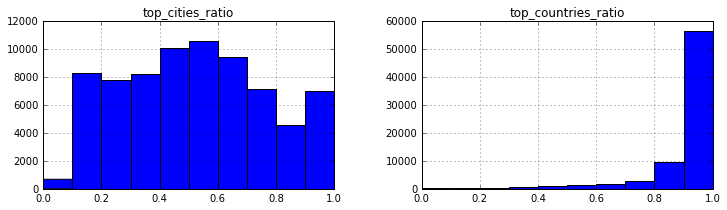

In [22]:
df[['top_cities_ratio', 'top_countries_ratio']].hist(figsize=(12,3))